Berceley Deep RL course. Fall 2017
http://rll.berkeley.edu/deeprlcourse/
Homework 1

## Behavioral Cloning
1.  Run  behavioral  cloning  (BC)  and  report  results  on  two  other  tasks  –  one  task  where  a  behavioral
cloning agent achieves comparable performance to the expert, and one task where it does not.  When
providing  results,  report  the  mean  and  standard  deviation  of  the  return  over  multiple  rollouts  in  a
table, and state which task was used.  Be sure to set up a fair comparison, in terms of network size,
amount of data, and number of training iterations, and provide these details (and any others you feel
are appropriate) in the table caption.
1
2.  Experiment with one hyperparameter that affects the performance of the behavioral cloning agent, such
as the number of demonstrations, the number of training epochs, the variance of the expert policy, or
something that you come up with yourself.  For one of the tasks used in the previous question, show a
graph of how the BC agent’s performance varies with the value of this hyperparameter, and state the
hyperparameter and a brief rationale for why you chose it in the caption for the graph.

In [1]:
import gym
 
#env = gym.make('Hopper-v1')

In [2]:
import time
import math
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

### Feed forward nn

In [3]:
class FFN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2,output_size,dropout_rate = 0.3):
        super(FFN, self).__init__()
        self.dropout_rate = dropout_rate
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.drop1  = nn.Dropout(p = self.dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.drop2  = nn.Dropout(p = self.dropout_rate)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = self.fc3(x)
        return x.view(x.size(0), -1)
    
    def set_dropout_rate(self, p):
        self.dropout_rate = p
        


In [4]:
criterion = torch.nn.L1Loss()

# Training function
def train_ffn(states_tensor, actions_tensor,learning_rate):
    tmp_loss = 0
    
    ffn.zero_grad()

    output = ffn(states_tensor)               # Predict action
    loss = criterion(output, actions_tensor)  # Calculate error
    tmp_loss += loss.data[0]
    loss.backward()                              # Error backpropagation

    for p in ffn.parameters():                   # Update net's parameters
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, tmp_loss 

In [5]:
#!/usr/bin/env python

"""
Code to load an expert policy and generate roll-out data for behavioral cloning.
Example usage:
    python run_expert.py experts/Humanoid-v1.pkl Humanoid-v1 --render \
            --num_rollouts 20

Author of this script and included expert policies: Jonathan Ho (hoj@openai.com)
"""

import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy
import pandas as pd

minibatch_size = 8

def learn_imitatation_learning(ffn, args):
    
    print('loading and building expert policy')
    target_policy_fn = load_policy.load_policy(args.expert_policy_file)
    print('loaded and built')

    with tf.Session():
        tf_util.initialize()

        import gym
        env = gym.make(args.envname)
        max_steps = args.max_timesteps or env.spec.timestep_limit

        returns = []
        observations = []
        actions = []
        for i in range(args.num_rollouts):
            #print('iter', i)
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            while not done:
                action = target_policy_fn(obs[None,:])
                observations.append(obs)
                actions.append(action)
                obs, r, done, _ = env.step(action)
                totalr += r
                steps += 1
                
                if args.render:
                    env.render()
                if steps % minibatch_size == 0: 
                    _, error = train_ffn(Variable(torch.Tensor(observations[-minibatch_size:])), 
                                         Variable(torch.Tensor(np.array(actions[-minibatch_size:])[:,0,:])),
                                         learning_rate
                                        )
                    #print("%i/%i, Error %f"%(steps, max_steps,error))
                    
                    
                if steps >= max_steps:
                    break
            returns.append(totalr)

#         print('returns', returns)
#         print('mean return', np.mean(returns))
#         print('std of return', np.std(returns))

#         expert_data = {'observations': np.array(observations),
#                        'actions': np.array(actions)}
        return returns,error
        

#Evaluate learned policy
def evaluate_imitation_learning(ffn, args):
    dropout_rate = ffn.dropout_rate
    ffn.dropout_rate = 0
    env = gym.make(args.envname)
    max_steps = args.max_timesteps or env.spec.timestep_limit

    returns = []
    observations = []
    actions = []
    for i in range(args.num_rollouts):
        #print('iter', i)
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done:
            action = ffn(Variable(torch.Tensor(obs))).data.numpy()  
            observations.append(obs)
            actions.append(action)
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1

            if args.render:
                env.render()

            if steps >= max_steps:
                break
            
        #print(totalr)
        returns.append(totalr)

#     print('returns', returns)
#     print('mean return', np.mean(returns))
#     print('std of return', np.std(returns))

#     expert_data = {'observations': np.array(observations),
#                    'actions': np.array(actions)}
        ffn.dropout_rate = dropout_rate
        return returns


In [6]:
! ls experts/

Ant-v1.pkl	    Hopper-v1.pkl    Reacher-v1.pkl
HalfCheetah-v1.pkl  Humanoid-v1.pkl  Walker2d-v1.pkl


### Train loop

In [11]:
learning_rate = 1e-2

envname = 'Walker2d-v1'
env = gym.make(envname)
#with gym.make(envname) as env:
state_shape = env.observation_space.shape[0]
actions_shape = env.action_space.shape[0]

print('Starting {} environment. State space dim {}, action space dim {}.'.format(
    envname,
    state_shape,
    actions_shape)
     )

ffn = FFN(state_shape, 128, 64,actions_shape,dropout_rate = 0)

learn_args = pd.Series({
        'expert_policy_file':'experts/' + envname + '.pkl',
        'envname': envname,
        'max_timesteps': None,
        'num_rollouts':2,
        'render': False
    })


eval_args = pd.Series({
        'envname': envname,
        'max_timesteps': None,
        'num_rollouts':2,
        'render': False
    })

n_iter = 300

results = []
for i in range(n_iter):
    experts_returns, error = learn_imitatation_learning(ffn, learn_args)
    agent_returns   = evaluate_imitation_learning(ffn, eval_args)
    print(i, np.mean(experts_returns),np.mean(error), np.mean(agent_returns),np.std(agent_returns))
    results.append((np.mean(experts_returns),np.mean(error),np.mean(agent_returns),np.std(agent_returns)))


[2017-11-02 16:25:40,903] Making new env: Walker2d-v1


Starting Walker2d-v1 environment. State space dim 17, action space dim 6.
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:25:41,395] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:25:41,400] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:25:41,439] Making new env: Walker2d-v1
[2017-11-02 16:25:53,426] Making new env: Walker2d-v1


0 5521.66737634 0.657711744308 8.43933974351 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:25:53,765] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:25:53,795] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:25:53,829] Making new env: Walker2d-v1
[2017-11-02 16:26:05,094] Making new env: Walker2d-v1


1 5551.88777828 0.623382925987 -6.6724634574 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:26:05,341] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:26:05,368] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:26:05,416] Making new env: Walker2d-v1
[2017-11-02 16:26:15,731] Making new env: Walker2d-v1


2 5516.45270272 0.486542910337 -9.0258438584 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:26:15,974] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:26:15,995] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:26:16,045] Making new env: Walker2d-v1
[2017-11-02 16:26:26,363] Making new env: Walker2d-v1


3 5505.68145095 0.475203990936 -8.11149530466 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:26:26,635] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:26:26,663] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:26:26,712] Making new env: Walker2d-v1
[2017-11-02 16:26:37,795] Making new env: Walker2d-v1


4 5482.72296627 0.340897232294 1.38070702214 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:26:38,099] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:26:38,126] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:26:38,173] Making new env: Walker2d-v1
[2017-11-02 16:26:48,717] Making new env: Walker2d-v1


5 5604.86512117 0.660210728645 -7.59986307384 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:26:48,956] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:26:48,982] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:26:49,050] Making new env: Walker2d-v1
[2017-11-02 16:26:59,640] Making new env: Walker2d-v1


6 5454.68285397 0.415765732527 1.46680785614 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:26:59,940] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:26:59,962] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:27:00,034] Making new env: Walker2d-v1
[2017-11-02 16:27:10,687] Making new env: Walker2d-v1


7 5501.32980686 0.339099407196 1.76399668588 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:27:10,982] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:27:11,004] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:27:11,084] Making new env: Walker2d-v1
[2017-11-02 16:27:21,924] Making new env: Walker2d-v1


8 5592.3007053 0.348105162382 1.5480038809 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:27:22,224] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:27:22,252] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:27:22,335] Making new env: Walker2d-v1
[2017-11-02 16:27:32,924] Making new env: Walker2d-v1


9 5564.6951932 0.251958221197 2.93062214727 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:27:33,220] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:27:33,247] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:27:33,326] Making new env: Walker2d-v1
[2017-11-02 16:27:43,527] Making new env: Walker2d-v1


10 5505.53359528 0.231136739254 2.53227525085 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:27:43,837] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:27:43,857] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:27:43,953] Making new env: Walker2d-v1
[2017-11-02 16:27:55,392] Making new env: Walker2d-v1


11 5512.4116704 0.592516362667 3.1191107318 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:27:55,726] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:27:55,744] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:27:55,813] Making new env: Walker2d-v1
[2017-11-02 16:28:07,531] Making new env: Walker2d-v1


12 5500.8047615 0.407788962126 3.85799342967 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:28:07,831] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:28:07,854] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:28:07,960] Making new env: Walker2d-v1
[2017-11-02 16:28:18,259] Making new env: Walker2d-v1


13 5500.68502317 0.360417574644 2.80359068132 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:28:18,557] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:28:18,571] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:28:18,659] Making new env: Walker2d-v1
[2017-11-02 16:28:29,004] Making new env: Walker2d-v1


14 5478.65572051 0.24673075974 3.00773458227 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:28:29,288] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:28:29,316] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:28:29,425] Making new env: Walker2d-v1
[2017-11-02 16:28:40,450] Making new env: Walker2d-v1


15 5573.96394301 0.307030767202 3.05904336878 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:28:40,726] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:28:40,754] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:28:40,862] Making new env: Walker2d-v1
[2017-11-02 16:28:51,087] Making new env: Walker2d-v1


16 5505.00656577 0.290064066648 3.38722970946 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:28:51,359] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:28:51,387] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:28:51,546] Making new env: Walker2d-v1
[2017-11-02 16:29:01,905] Making new env: Walker2d-v1


17 5459.40595523 0.444228380919 3.86493761588 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:29:02,182] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:29:02,210] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:29:02,338] Making new env: Walker2d-v1
[2017-11-02 16:29:12,656] Making new env: Walker2d-v1


18 5498.18740545 0.645536363125 3.21388183892 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:29:12,949] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:29:12,973] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:29:13,100] Making new env: Walker2d-v1
[2017-11-02 16:29:23,571] Making new env: Walker2d-v1


19 5527.54428583 0.361762434244 2.39207594466 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:29:23,842] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:29:23,866] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:29:24,007] Making new env: Walker2d-v1
[2017-11-02 16:29:34,537] Making new env: Walker2d-v1


20 5503.07731031 0.226195648313 2.64372049267 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:29:34,816] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:29:34,832] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:29:34,982] Making new env: Walker2d-v1
[2017-11-02 16:29:45,821] Making new env: Walker2d-v1


21 5502.94392871 0.707551717758 3.17955229175 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:29:46,089] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:29:46,100] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:29:46,209] Making new env: Walker2d-v1
[2017-11-02 16:29:57,428] Making new env: Walker2d-v1


22 5569.09489479 0.264471799135 2.99725982607 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:29:57,703] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:29:57,725] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:29:57,871] Making new env: Walker2d-v1
[2017-11-02 16:30:08,400] Making new env: Walker2d-v1


23 5488.67216832 0.203153327107 4.02764397468 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:30:08,690] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:30:08,715] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:30:08,886] Making new env: Walker2d-v1
[2017-11-02 16:30:19,415] Making new env: Walker2d-v1


24 5580.27952337 0.33861592412 4.57410439115 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:30:19,685] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:30:19,708] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:30:19,874] Making new env: Walker2d-v1
[2017-11-02 16:30:30,142] Making new env: Walker2d-v1


25 5488.63360875 0.276722431183 46.0210694792 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:30:30,609] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:30:30,625] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:30:30,800] Making new env: Walker2d-v1
[2017-11-02 16:30:42,122] Making new env: Walker2d-v1


26 5578.05819023 0.320761233568 3.41848079258 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:30:42,411] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:30:42,429] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:30:42,600] Making new env: Walker2d-v1
[2017-11-02 16:30:57,253] Making new env: Walker2d-v1


27 5508.10808395 0.179574847221 4.11892997828 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:30:57,542] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:30:57,569] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:30:57,751] Making new env: Walker2d-v1
[2017-11-02 16:31:11,340] Making new env: Walker2d-v1


28 5560.10012436 0.226646900177 40.4101268986 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:31:11,802] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:31:11,829] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:31:11,998] Making new env: Walker2d-v1
[2017-11-02 16:31:25,467] Making new env: Walker2d-v1


29 5436.2785736 0.160800278187 43.5989603886 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:31:25,954] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:31:25,976] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:31:26,164] Making new env: Walker2d-v1
[2017-11-02 16:31:40,031] Making new env: Walker2d-v1


30 5582.1372193 0.233915254474 3.57177136192 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:31:40,343] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:31:40,365] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:31:40,560] Making new env: Walker2d-v1
[2017-11-02 16:31:55,870] Making new env: Walker2d-v1


31 5498.62772185 0.278007626534 38.6116273289 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:31:56,392] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:31:56,409] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:31:56,641] Making new env: Walker2d-v1
[2017-11-02 16:32:11,958] Making new env: Walker2d-v1


32 5532.31953388 0.451364636421 36.1412120961 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:32:12,410] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:32:12,436] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:32:12,640] Making new env: Walker2d-v1
[2017-11-02 16:32:26,692] Making new env: Walker2d-v1


33 5528.64294232 0.434799522161 50.952841575 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:32:27,199] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:32:27,226] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:32:27,459] Making new env: Walker2d-v1
[2017-11-02 16:32:42,303] Making new env: Walker2d-v1


34 5485.66185205 0.237397611141 43.0761960742 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:32:42,829] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:32:42,854] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:32:43,091] Making new env: Walker2d-v1
[2017-11-02 16:32:57,548] Making new env: Walker2d-v1


35 5565.04932003 0.25539162755 47.886979906 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:32:58,059] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:32:58,080] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:32:58,315] Making new env: Walker2d-v1
[2017-11-02 16:33:12,785] Making new env: Walker2d-v1


36 5499.1905991 0.168309524655 45.7025084121 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:33:13,266] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:33:13,294] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:33:13,536] Making new env: Walker2d-v1
[2017-11-02 16:33:27,360] Making new env: Walker2d-v1


37 5365.36415807 0.362315148115 35.280976414 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:33:27,806] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:33:27,834] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:33:28,065] Making new env: Walker2d-v1
[2017-11-02 16:33:41,923] Making new env: Walker2d-v1


38 5510.6745472 0.185374423862 72.8717174421 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:33:42,493] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:33:42,518] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:33:42,758] Making new env: Walker2d-v1
[2017-11-02 16:33:57,947] Making new env: Walker2d-v1


39 5478.91495704 0.239631548524 58.033984567 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:33:58,477] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:33:58,504] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:33:58,759] Making new env: Walker2d-v1
[2017-11-02 16:34:12,963] Making new env: Walker2d-v1


40 5538.95446089 0.204276010394 44.3058864413 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:34:13,447] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:34:13,473] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:34:13,754] Making new env: Walker2d-v1
[2017-11-02 16:34:27,874] Making new env: Walker2d-v1


41 5561.80434535 0.241124793887 1047.71730299 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:34:34,629] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:34:34,659] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:34:34,941] Making new env: Walker2d-v1
[2017-11-02 16:34:49,256] Making new env: Walker2d-v1


42 5599.1044036 0.251868188381 61.1325030501 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:34:49,920] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:34:49,940] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:34:50,268] Making new env: Walker2d-v1
[2017-11-02 16:35:03,619] Making new env: Walker2d-v1


43 5470.65366136 0.288188070059 30.1416879402 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:35:04,045] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:35:04,073] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:35:04,310] Making new env: Walker2d-v1
[2017-11-02 16:35:16,946] Making new env: Walker2d-v1


44 5575.62456188 0.436129420996 1048.41494261 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:35:22,780] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:35:22,801] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:35:23,047] Making new env: Walker2d-v1
[2017-11-02 16:35:36,090] Making new env: Walker2d-v1


45 5556.09765628 0.295177280903 1050.0208886 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:35:42,194] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:35:42,218] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:35:42,412] Making new env: Walker2d-v1
[2017-11-02 16:35:55,812] Making new env: Walker2d-v1


46 5494.66841496 0.412064313889 54.4720462259 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:35:56,275] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:35:56,295] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:35:56,515] Making new env: Walker2d-v1
[2017-11-02 16:36:08,994] Making new env: Walker2d-v1


47 5524.32284744 0.292781770229 1049.96780601 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:36:14,847] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:36:14,867] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:36:15,121] Making new env: Walker2d-v1
[2017-11-02 16:36:28,864] Making new env: Walker2d-v1


48 5536.27829179 0.158288523555 819.556492589 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:36:33,501] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:36:33,530] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:36:33,800] Making new env: Walker2d-v1
[2017-11-02 16:36:46,520] Making new env: Walker2d-v1


49 5530.08036193 0.321697235107 1044.78218325 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:36:52,278] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:36:52,303] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:36:52,572] Making new env: Walker2d-v1
[2017-11-02 16:37:04,884] Making new env: Walker2d-v1


50 5523.81651842 0.217093765736 1044.43169092 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:37:10,620] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:37:10,651] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:37:10,907] Making new env: Walker2d-v1
[2017-11-02 16:37:23,584] Making new env: Walker2d-v1


51 5402.09060602 0.203857600689 62.7297895083 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:37:24,036] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:37:24,055] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:37:24,344] Making new env: Walker2d-v1
[2017-11-02 16:37:36,600] Making new env: Walker2d-v1


52 5521.259838 0.277463257313 1035.13708896 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:37:42,926] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:37:42,953] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:37:43,252] Making new env: Walker2d-v1
[2017-11-02 16:37:56,790] Making new env: Walker2d-v1


53 5448.71239683 0.147371783853 1045.99981334 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:38:02,526] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:38:02,550] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:38:02,846] Making new env: Walker2d-v1
[2017-11-02 16:38:17,491] Making new env: Walker2d-v1


54 5434.29520981 0.16687835753 1048.58259424 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:38:23,583] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:38:23,612] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:38:23,915] Making new env: Walker2d-v1
[2017-11-02 16:38:37,527] Making new env: Walker2d-v1


55 5504.21489996 0.350363612175 28.5514039844 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:38:37,892] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:38:37,918] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:38:38,236] Making new env: Walker2d-v1
[2017-11-02 16:38:51,067] Making new env: Walker2d-v1


56 5456.06274262 0.244608148932 47.0716702391 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:38:51,537] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:38:51,560] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:38:51,936] Making new env: Walker2d-v1
[2017-11-02 16:39:04,833] Making new env: Walker2d-v1


57 5453.46152785 0.189545989037 508.384785054 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:39:06,794] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:39:06,823] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:39:07,160] Making new env: Walker2d-v1
[2017-11-02 16:39:20,179] Making new env: Walker2d-v1


58 5503.0200085 0.158043056726 31.8046959471 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:39:20,638] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:39:20,669] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:39:20,991] Making new env: Walker2d-v1
[2017-11-02 16:39:33,766] Making new env: Walker2d-v1


59 5486.40518996 0.152086064219 347.021974125 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:39:34,932] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:39:34,962] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:39:35,297] Making new env: Walker2d-v1
[2017-11-02 16:39:49,160] Making new env: Walker2d-v1


60 5539.64871827 0.407415181398 347.901363051 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:39:50,325] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:39:50,352] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:39:50,714] Making new env: Walker2d-v1
[2017-11-02 16:40:04,243] Making new env: Walker2d-v1


61 5542.72443469 0.468948364258 330.733900358 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:40:05,374] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:40:05,395] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:40:05,726] Making new env: Walker2d-v1
[2017-11-02 16:40:18,571] Making new env: Walker2d-v1


62 5582.74831036 0.192312479019 1028.8446593 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:40:24,555] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:40:24,578] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:40:24,921] Making new env: Walker2d-v1
[2017-11-02 16:40:39,984] Making new env: Walker2d-v1


63 5375.78555104 0.245377227664 1046.01320727 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:40:46,075] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:40:46,106] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:40:46,458] Making new env: Walker2d-v1
[2017-11-02 16:40:59,433] Making new env: Walker2d-v1


64 5517.72803546 0.264180511236 477.053567397 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:41:01,252] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:41:01,280] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:41:01,651] Making new env: Walker2d-v1
[2017-11-02 16:41:14,289] Making new env: Walker2d-v1


65 5507.25130963 0.408540487289 368.603237147 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:41:15,493] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:41:15,514] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:41:15,882] Making new env: Walker2d-v1
[2017-11-02 16:41:28,809] Making new env: Walker2d-v1


66 5511.76820663 0.299112379551 356.576653576 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:41:30,028] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:41:30,052] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:41:30,425] Making new env: Walker2d-v1
[2017-11-02 16:41:40,787] Making new env: Walker2d-v1


67 4221.44196219 0.206279650331 287.727287353 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:41:41,778] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:41:41,804] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:41:42,202] Making new env: Walker2d-v1
[2017-11-02 16:41:56,301] Making new env: Walker2d-v1


68 5544.78443659 0.147477716208 358.567108692 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:41:57,593] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:41:57,615] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:41:58,009] Making new env: Walker2d-v1
[2017-11-02 16:42:10,927] Making new env: Walker2d-v1


69 5536.9011292 0.165269061923 276.0454625 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:42:11,879] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:42:11,904] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:42:12,290] Making new env: Walker2d-v1
[2017-11-02 16:42:25,182] Making new env: Walker2d-v1


70 5380.43337392 0.260398566723 396.593168256 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:42:26,713] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:42:26,741] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:42:27,144] Making new env: Walker2d-v1
[2017-11-02 16:42:40,416] Making new env: Walker2d-v1


71 5550.6502892 0.211838617921 406.086030937 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:42:41,905] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:42:41,934] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:42:42,335] Making new env: Walker2d-v1
[2017-11-02 16:42:55,070] Making new env: Walker2d-v1


72 5541.12486362 0.135500982404 370.621736371 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:42:56,382] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:42:56,405] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:42:56,803] Making new env: Walker2d-v1
[2017-11-02 16:43:09,882] Making new env: Walker2d-v1


73 5581.89323979 0.564527511597 527.001964723 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:43:12,063] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:43:12,083] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:43:12,453] Making new env: Walker2d-v1
[2017-11-02 16:43:25,255] Making new env: Walker2d-v1


74 5568.66413266 0.374512791634 336.452847056 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:43:26,445] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:43:26,469] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:43:26,884] Making new env: Walker2d-v1
[2017-11-02 16:43:40,023] Making new env: Walker2d-v1


75 5508.66163077 0.13469786942 285.933217172 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:43:41,085] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:43:41,117] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:43:41,535] Making new env: Walker2d-v1
[2017-11-02 16:43:55,242] Making new env: Walker2d-v1


76 5442.81336705 0.214328750968 340.745077324 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:43:56,630] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:43:56,661] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:43:57,114] Making new env: Walker2d-v1
[2017-11-02 16:44:10,151] Making new env: Walker2d-v1


77 5564.99509225 0.403610616922 382.328313339 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:44:12,088] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:44:12,116] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:44:12,486] Making new env: Walker2d-v1
[2017-11-02 16:44:25,482] Making new env: Walker2d-v1


78 5436.70897146 0.177027404308 388.440625094 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:44:26,953] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:44:26,980] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:44:27,356] Making new env: Walker2d-v1
[2017-11-02 16:44:42,006] Making new env: Walker2d-v1


79 5544.59641813 0.237114667892 384.927658844 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:44:43,773] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:44:43,784] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:44:44,247] Making new env: Walker2d-v1
[2017-11-02 16:44:57,145] Making new env: Walker2d-v1


80 5517.1652947 0.136472657323 228.212718198 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:44:58,075] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:44:58,095] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:44:58,503] Making new env: Walker2d-v1
[2017-11-02 16:45:11,343] Making new env: Walker2d-v1


81 5489.23743618 0.200052857399 380.673824823 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:45:12,758] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:45:12,776] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:45:13,164] Making new env: Walker2d-v1
[2017-11-02 16:45:26,360] Making new env: Walker2d-v1


82 5513.12894169 0.145459532738 230.501269472 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:45:27,242] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:45:27,271] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:45:27,702] Making new env: Walker2d-v1
[2017-11-02 16:45:40,757] Making new env: Walker2d-v1


83 5581.27133855 0.158325731754 1046.19365934 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:45:46,973] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:45:46,988] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:45:47,477] Making new env: Walker2d-v1
[2017-11-02 16:46:01,467] Making new env: Walker2d-v1


84 5442.95397645 0.414722323418 214.935699069 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:46:02,381] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:46:02,404] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:46:02,888] Making new env: Walker2d-v1
[2017-11-02 16:46:15,748] Making new env: Walker2d-v1


85 5538.85367847 0.209126666188 659.323989364 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:46:18,749] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:46:18,774] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:46:19,197] Making new env: Walker2d-v1
[2017-11-02 16:46:32,096] Making new env: Walker2d-v1


86 5532.22142445 0.172404631972 219.232542411 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:46:32,973] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:46:33,001] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:46:33,464] Making new env: Walker2d-v1
[2017-11-02 16:46:47,041] Making new env: Walker2d-v1


87 5507.99123139 0.251469880342 315.927538364 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:46:48,170] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:46:48,188] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:46:48,667] Making new env: Walker2d-v1
[2017-11-02 16:47:01,751] Making new env: Walker2d-v1


88 5497.2276126 0.240421876311 267.464177393 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:47:02,776] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:47:02,800] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:47:03,276] Making new env: Walker2d-v1
[2017-11-02 16:47:15,914] Making new env: Walker2d-v1


89 5445.5594905 0.318676143885 217.708827852 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:47:16,845] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:47:16,876] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:47:17,287] Making new env: Walker2d-v1
[2017-11-02 16:47:30,618] Making new env: Walker2d-v1


90 5556.48962259 0.23720896244 337.274871033 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:47:31,872] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:47:31,894] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:47:32,333] Making new env: Walker2d-v1
[2017-11-02 16:47:45,254] Making new env: Walker2d-v1


91 5524.7559752 0.118896126747 226.81650713 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:47:46,331] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:47:46,344] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:47:46,822] Making new env: Walker2d-v1
[2017-11-02 16:48:01,189] Making new env: Walker2d-v1


92 5515.66145819 0.245648011565 296.61116192 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:48:02,305] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:48:02,325] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:48:02,793] Making new env: Walker2d-v1
[2017-11-02 16:48:15,639] Making new env: Walker2d-v1


93 5501.57764691 0.127042755485 336.512429936 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:48:16,892] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:48:16,914] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:48:17,383] Making new env: Walker2d-v1
[2017-11-02 16:48:30,005] Making new env: Walker2d-v1


94 5559.98315678 0.123476147652 338.639871386 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:48:31,109] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:48:31,136] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:48:31,538] Making new env: Walker2d-v1
[2017-11-02 16:48:45,594] Making new env: Walker2d-v1


95 5305.39065171 0.325874835253 59.7998895178 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:48:47,134] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:48:47,142] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:48:47,704] Making new env: Walker2d-v1
[2017-11-02 16:49:01,895] Making new env: Walker2d-v1


96 5516.2447164 0.203276351094 214.166925686 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:49:02,538] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:49:02,560] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:49:02,972] Making new env: Walker2d-v1
[2017-11-02 16:49:12,255] Making new env: Walker2d-v1


97 5549.63148969 0.228790819645 290.152132635 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:49:13,115] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:49:13,137] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:49:13,465] Making new env: Walker2d-v1
[2017-11-02 16:49:22,883] Making new env: Walker2d-v1


98 5542.97032078 0.202558711171 304.450095441 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:49:23,672] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:49:23,701] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:49:24,104] Making new env: Walker2d-v1
[2017-11-02 16:49:33,152] Making new env: Walker2d-v1


99 5503.9925077 0.274865955114 276.916270982 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:49:34,071] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:49:34,086] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:49:34,511] Making new env: Walker2d-v1
[2017-11-02 16:49:43,676] Making new env: Walker2d-v1


100 5471.72108477 0.0904140546918 299.98273671 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:49:44,481] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:49:44,508] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:49:44,863] Making new env: Walker2d-v1
[2017-11-02 16:49:55,353] Making new env: Walker2d-v1


101 5529.14953434 0.677694320679 168.368118623 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:49:57,135] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:49:57,155] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:49:57,516] Making new env: Walker2d-v1
[2017-11-02 16:50:07,064] Making new env: Walker2d-v1


102 5567.15336205 0.274761408567 278.02267392 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:50:07,829] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:50:07,856] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:50:08,294] Making new env: Walker2d-v1
[2017-11-02 16:50:17,292] Making new env: Walker2d-v1


103 5488.44379215 0.155550509691 220.804825437 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:50:18,076] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:50:18,095] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:50:18,480] Making new env: Walker2d-v1
[2017-11-02 16:50:27,722] Making new env: Walker2d-v1


104 5545.31992675 0.411207228899 896.721010307 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:50:32,413] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:50:32,436] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:50:32,880] Making new env: Walker2d-v1
[2017-11-02 16:50:43,079] Making new env: Walker2d-v1


105 5536.92347571 0.33566775918 272.950868363 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:50:43,867] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:50:43,893] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:50:44,253] Making new env: Walker2d-v1
[2017-11-02 16:50:53,388] Making new env: Walker2d-v1


106 5485.2814878 0.284540981054 151.987631743 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:50:53,863] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:50:53,886] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:50:54,308] Making new env: Walker2d-v1
[2017-11-02 16:51:03,884] Making new env: Walker2d-v1


107 5522.96698078 0.183995068073 312.751089786 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:51:04,768] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:51:04,784] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:51:05,244] Making new env: Walker2d-v1
[2017-11-02 16:51:14,451] Making new env: Walker2d-v1


108 5549.93833396 0.143085166812 325.420258525 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:51:15,230] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:51:15,247] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:51:15,657] Making new env: Walker2d-v1
[2017-11-02 16:51:25,053] Making new env: Walker2d-v1


109 5561.73091118 0.206673398614 291.539651869 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:51:25,897] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:51:25,921] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:51:26,303] Making new env: Walker2d-v1
[2017-11-02 16:51:36,092] Making new env: Walker2d-v1


110 5592.51213469 0.333329111338 309.132137832 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:51:36,985] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:51:37,007] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:51:37,375] Making new env: Walker2d-v1
[2017-11-02 16:51:47,149] Making new env: Walker2d-v1


111 5549.07679527 0.129360809922 248.97194156 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:51:48,031] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:51:48,044] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:51:48,498] Making new env: Walker2d-v1
[2017-11-02 16:51:59,286] Making new env: Walker2d-v1


112 5555.16700541 0.186052128673 284.168884076 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:52:00,002] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:52:00,027] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:52:00,515] Making new env: Walker2d-v1
[2017-11-02 16:52:09,903] Making new env: Walker2d-v1


113 5547.95748204 0.103154592216 210.419297948 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:52:10,580] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:52:10,603] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:52:10,991] Making new env: Walker2d-v1
[2017-11-02 16:52:20,490] Making new env: Walker2d-v1


114 5417.36701978 0.114400215447 291.962158359 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:52:21,277] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:52:21,305] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:52:21,746] Making new env: Walker2d-v1
[2017-11-02 16:52:31,373] Making new env: Walker2d-v1


115 5538.97698569 0.354117065668 252.247802401 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:52:31,985] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:52:32,009] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:52:32,525] Making new env: Walker2d-v1
[2017-11-02 16:52:43,167] Making new env: Walker2d-v1


116 5542.10713253 0.26575794816 323.370243976 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:52:44,469] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:52:44,503] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:52:45,109] Making new env: Walker2d-v1
[2017-11-02 16:52:54,961] Making new env: Walker2d-v1


117 5588.26642629 0.139866694808 252.882459383 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:52:55,965] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:52:55,972] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:52:56,489] Making new env: Walker2d-v1
[2017-11-02 16:53:07,379] Making new env: Walker2d-v1


118 5389.99035455 0.0974809229374 282.80318464 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:53:08,015] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:53:08,045] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:53:08,569] Making new env: Walker2d-v1
[2017-11-02 16:53:18,061] Making new env: Walker2d-v1


119 5495.44327604 0.296377569437 175.16108376 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:53:18,703] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:53:18,730] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:53:19,172] Making new env: Walker2d-v1
[2017-11-02 16:53:28,578] Making new env: Walker2d-v1


120 5559.96951141 0.201524540782 167.460888754 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:53:29,128] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:53:29,153] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:53:29,656] Making new env: Walker2d-v1
[2017-11-02 16:53:39,247] Making new env: Walker2d-v1


121 5464.24238908 0.405060619116 184.064555075 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:53:39,658] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:53:39,690] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:53:40,229] Making new env: Walker2d-v1
[2017-11-02 16:53:50,467] Making new env: Walker2d-v1


122 5525.17582123 0.136122956872 336.866429371 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:53:51,245] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:53:51,268] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:53:51,784] Making new env: Walker2d-v1
[2017-11-02 16:54:01,776] Making new env: Walker2d-v1


123 5528.22010091 0.120034776628 162.73673577 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:54:02,272] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:54:02,291] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:54:02,798] Making new env: Walker2d-v1
[2017-11-02 16:54:12,105] Making new env: Walker2d-v1


124 5556.04791659 0.141102597117 278.316979787 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:54:13,057] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:54:13,068] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:54:13,500] Making new env: Walker2d-v1
[2017-11-02 16:54:24,124] Making new env: Walker2d-v1


125 5463.69948285 0.479508280754 326.232308736 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:54:25,140] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:54:25,161] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:54:25,627] Making new env: Walker2d-v1
[2017-11-02 16:54:35,143] Making new env: Walker2d-v1


126 5501.96408351 0.136010274291 189.810301165 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:54:35,737] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:54:35,750] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:54:36,367] Making new env: Walker2d-v1
[2017-11-02 16:54:45,938] Making new env: Walker2d-v1


127 5554.46141073 0.159588009119 288.652787094 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:54:46,729] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:54:46,752] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:54:47,283] Making new env: Walker2d-v1
[2017-11-02 16:54:56,171] Making new env: Walker2d-v1


128 5590.05105793 0.156049907207 424.418834242 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:54:57,127] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:54:57,146] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:54:57,536] Making new env: Walker2d-v1
[2017-11-02 16:55:06,623] Making new env: Walker2d-v1


129 5512.9364541 0.162151038647 159.946849351 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:55:07,219] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:55:07,245] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:55:07,703] Making new env: Walker2d-v1
[2017-11-02 16:55:17,239] Making new env: Walker2d-v1


130 5534.6529736 0.327404916286 173.826556973 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:55:17,813] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:55:17,837] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:55:18,356] Making new env: Walker2d-v1
[2017-11-02 16:55:27,883] Making new env: Walker2d-v1


131 5545.03269852 0.23469376564 164.734444399 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:55:28,396] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:55:28,423] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:55:28,996] Making new env: Walker2d-v1
[2017-11-02 16:55:38,189] Making new env: Walker2d-v1


132 5544.26207252 0.168147563934 191.494240312 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:55:38,865] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:55:38,882] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:55:39,338] Making new env: Walker2d-v1
[2017-11-02 16:55:49,274] Making new env: Walker2d-v1


133 5569.77759031 0.220538780093 352.802080042 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:55:50,349] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:55:50,361] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:55:50,933] Making new env: Walker2d-v1
[2017-11-02 16:56:01,010] Making new env: Walker2d-v1


134 5538.17123978 0.232340395451 188.343026168 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:56:01,669] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:56:01,695] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:56:02,188] Making new env: Walker2d-v1
[2017-11-02 16:56:11,622] Making new env: Walker2d-v1


135 5531.81859644 0.199809268117 328.528551071 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:56:12,500] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:56:12,516] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:56:13,001] Making new env: Walker2d-v1
[2017-11-02 16:56:22,335] Making new env: Walker2d-v1


136 5526.29033341 0.186227604747 155.240391551 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:56:22,781] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:56:22,803] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:56:23,404] Making new env: Walker2d-v1
[2017-11-02 16:56:32,706] Making new env: Walker2d-v1


137 5461.509935 0.0851222500205 184.181966188 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:56:33,353] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:56:33,370] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:56:33,844] Making new env: Walker2d-v1
[2017-11-02 16:56:43,937] Making new env: Walker2d-v1


138 5534.90176955 0.157354667783 323.75240857 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:56:44,740] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:56:44,759] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:56:45,344] Making new env: Walker2d-v1
[2017-11-02 16:56:54,331] Making new env: Walker2d-v1


139 5511.08404158 0.149506881833 230.592481325 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:56:54,889] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:56:54,912] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:56:55,499] Making new env: Walker2d-v1
[2017-11-02 16:57:05,007] Making new env: Walker2d-v1


140 5535.0678339 0.30506888032 179.963656094 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:57:05,622] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:57:05,646] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:57:06,094] Making new env: Walker2d-v1
[2017-11-02 16:57:15,434] Making new env: Walker2d-v1


141 5485.84063734 0.179235354066 238.620838497 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:57:16,016] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:57:16,040] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:57:16,641] Making new env: Walker2d-v1
[2017-11-02 16:57:25,703] Making new env: Walker2d-v1


142 5570.56639583 0.147662520409 477.87787932 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:57:26,971] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:57:26,990] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:57:27,584] Making new env: Walker2d-v1
[2017-11-02 16:57:36,442] Making new env: Walker2d-v1


143 5491.97056691 0.130411297083 289.014660403 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:57:37,225] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:57:37,242] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:57:37,720] Making new env: Walker2d-v1
[2017-11-02 16:57:47,260] Making new env: Walker2d-v1


144 5538.58241644 0.110996194184 176.98615278 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:57:48,040] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:57:48,048] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:57:48,756] Making new env: Walker2d-v1
[2017-11-02 16:58:00,448] Making new env: Walker2d-v1


145 5497.08511012 0.185990974307 184.48200052 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:58:01,024] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:58:01,052] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:58:01,655] Making new env: Walker2d-v1
[2017-11-02 16:58:12,278] Making new env: Walker2d-v1


146 5521.27967053 0.0922895595431 156.536145526 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:58:12,879] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:58:12,902] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:58:13,508] Making new env: Walker2d-v1
[2017-11-02 16:58:24,143] Making new env: Walker2d-v1


147 5483.29738022 0.16967792809 178.862713034 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:58:24,758] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:58:24,780] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:58:25,380] Making new env: Walker2d-v1
[2017-11-02 16:58:36,171] Making new env: Walker2d-v1


148 5483.3014625 0.174473777413 186.849791718 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:58:37,000] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:58:37,004] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:58:37,789] Making new env: Walker2d-v1
[2017-11-02 16:58:48,970] Making new env: Walker2d-v1


149 5520.15881549 0.114388085902 180.313011764 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:58:49,635] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:58:49,660] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:58:50,273] Making new env: Walker2d-v1
[2017-11-02 16:59:00,855] Making new env: Walker2d-v1


150 5582.29651309 0.286316215992 176.19332841 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:59:01,481] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:59:01,504] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:59:02,179] Making new env: Walker2d-v1
[2017-11-02 16:59:12,864] Making new env: Walker2d-v1


151 5497.12184899 0.220176339149 167.494420446 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:59:13,508] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:59:13,535] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:59:14,164] Making new env: Walker2d-v1
[2017-11-02 16:59:24,974] Making new env: Walker2d-v1


152 5489.69569446 0.20550340414 174.325980942 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:59:25,616] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:59:25,633] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:59:26,286] Making new env: Walker2d-v1
[2017-11-02 16:59:37,273] Making new env: Walker2d-v1


153 5514.80561987 0.150768071413 174.98576827 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:59:37,929] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:59:37,958] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:59:38,628] Making new env: Walker2d-v1
[2017-11-02 16:59:50,376] Making new env: Walker2d-v1


154 5548.08629121 0.117037944496 237.394040748 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:59:51,143] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:59:51,161] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:59:51,843] Making new env: Walker2d-v1
[2017-11-02 17:00:03,174] Making new env: Walker2d-v1


155 5556.28285397 0.213863715529 285.013398066 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:00:04,017] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:00:04,026] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:00:04,694] Making new env: Walker2d-v1
[2017-11-02 17:00:15,410] Making new env: Walker2d-v1


156 5503.34790391 0.119098722935 167.286234487 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:00:16,049] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:00:16,068] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:00:16,757] Making new env: Walker2d-v1
[2017-11-02 17:00:27,336] Making new env: Walker2d-v1


157 5534.17879269 0.0966449975967 186.283340404 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:00:27,910] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:00:27,937] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:00:28,609] Making new env: Walker2d-v1
[2017-11-02 17:00:39,972] Making new env: Walker2d-v1


158 5544.25186223 0.11726129055 371.262389154 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:00:41,060] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:00:41,081] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:00:41,754] Making new env: Walker2d-v1
[2017-11-02 17:00:52,480] Making new env: Walker2d-v1


159 5505.73737226 0.0972079411149 174.896261112 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:00:53,081] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:00:53,098] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:00:53,872] Making new env: Walker2d-v1
[2017-11-02 17:01:04,245] Making new env: Walker2d-v1


160 5554.13887849 0.427324771881 175.87836346 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:01:04,872] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:01:04,895] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:01:05,551] Making new env: Walker2d-v1
[2017-11-02 17:01:15,941] Making new env: Walker2d-v1


161 5523.8921399 0.118344604969 339.934552041 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:01:16,821] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:01:16,844] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:01:17,528] Making new env: Walker2d-v1
[2017-11-02 17:01:27,974] Making new env: Walker2d-v1


162 5500.04731576 0.279942512512 192.649660603 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:01:28,579] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:01:28,600] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:01:29,335] Making new env: Walker2d-v1
[2017-11-02 17:01:40,025] Making new env: Walker2d-v1


163 5490.1461496 0.265245437622 169.752702907 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:01:40,658] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:01:40,683] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:01:41,362] Making new env: Walker2d-v1
[2017-11-02 17:01:52,967] Making new env: Walker2d-v1


164 5538.80294034 0.182894840837 193.845555567 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:01:53,542] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:01:53,563] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:01:54,272] Making new env: Walker2d-v1
[2017-11-02 17:02:05,547] Making new env: Walker2d-v1


165 5507.56686609 0.15290863812 173.331049814 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:02:06,146] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:02:06,169] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:02:06,846] Making new env: Walker2d-v1
[2017-11-02 17:02:17,576] Making new env: Walker2d-v1


166 5479.73851196 0.142315387726 160.742345796 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:02:18,217] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:02:18,240] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:02:18,953] Making new env: Walker2d-v1
[2017-11-02 17:02:29,403] Making new env: Walker2d-v1


167 5356.18105035 0.313854783773 315.406322077 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:02:30,377] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:02:30,400] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:02:31,104] Making new env: Walker2d-v1
[2017-11-02 17:02:42,671] Making new env: Walker2d-v1


168 5496.80694741 0.176064550877 334.568990358 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:02:43,553] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:02:43,583] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:02:44,294] Making new env: Walker2d-v1
[2017-11-02 17:02:56,417] Making new env: Walker2d-v1


169 5531.52335605 0.213925883174 180.700579459 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:02:57,031] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:02:57,055] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:02:57,800] Making new env: Walker2d-v1
[2017-11-02 17:03:08,847] Making new env: Walker2d-v1


170 5560.16265999 0.181052207947 178.018699339 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:03:09,295] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:03:09,311] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:03:09,850] Making new env: Walker2d-v1
[2017-11-02 17:03:17,562] Making new env: Walker2d-v1


171 5304.40983805 0.119834929705 159.503375889 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:03:18,071] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:03:18,087] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:03:18,639] Making new env: Walker2d-v1
[2017-11-02 17:03:26,235] Making new env: Walker2d-v1


172 5543.02919809 0.147898152471 167.637326665 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:03:26,691] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:03:26,710] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:03:27,259] Making new env: Walker2d-v1
[2017-11-02 17:03:34,539] Making new env: Walker2d-v1


173 5552.99857277 0.093288205564 182.470401462 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:03:35,012] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:03:35,036] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:03:35,582] Making new env: Walker2d-v1
[2017-11-02 17:03:43,016] Making new env: Walker2d-v1


174 5487.96744798 0.181516051292 173.257866529 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:03:43,498] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:03:43,518] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:03:44,055] Making new env: Walker2d-v1
[2017-11-02 17:03:52,486] Making new env: Walker2d-v1


175 5529.78155527 0.101215578616 198.562131076 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:03:52,901] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:03:52,920] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:03:53,494] Making new env: Walker2d-v1
[2017-11-02 17:04:01,990] Making new env: Walker2d-v1


176 5412.47951808 0.20349560678 191.115318344 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:04:02,497] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:04:02,513] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:04:03,101] Making new env: Walker2d-v1
[2017-11-02 17:04:10,847] Making new env: Walker2d-v1


177 5480.79414472 0.179571509361 208.035852546 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:04:11,301] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:04:11,322] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:04:11,880] Making new env: Walker2d-v1
[2017-11-02 17:04:19,388] Making new env: Walker2d-v1


178 5482.34959968 0.206808209419 164.727972781 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:04:19,809] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:04:19,828] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:04:20,390] Making new env: Walker2d-v1
[2017-11-02 17:04:27,977] Making new env: Walker2d-v1


179 5521.56270772 0.126669332385 190.893654892 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:04:28,427] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:04:28,443] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:04:29,000] Making new env: Walker2d-v1
[2017-11-02 17:04:36,889] Making new env: Walker2d-v1


180 5584.64340901 0.191716432571 181.782811129 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:04:37,518] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:04:37,532] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:04:38,266] Making new env: Walker2d-v1
[2017-11-02 17:04:46,160] Making new env: Walker2d-v1


181 5328.40314641 0.311178684235 163.360596601 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:04:46,622] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:04:46,642] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:04:47,244] Making new env: Walker2d-v1
[2017-11-02 17:04:54,831] Making new env: Walker2d-v1


182 5509.55380437 0.169055104256 175.697558908 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:04:55,265] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:04:55,276] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:04:55,867] Making new env: Walker2d-v1
[2017-11-02 17:05:03,832] Making new env: Walker2d-v1


183 5389.43464474 0.328696638346 165.554509308 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:05:04,280] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:05:04,301] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:05:04,894] Making new env: Walker2d-v1
[2017-11-02 17:05:12,468] Making new env: Walker2d-v1


184 5418.41068531 0.327971637249 164.460657024 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:05:12,923] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:05:12,940] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:05:13,537] Making new env: Walker2d-v1
[2017-11-02 17:05:21,209] Making new env: Walker2d-v1


185 5583.90149493 0.14733915031 162.169191139 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:05:21,722] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:05:21,742] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:05:22,348] Making new env: Walker2d-v1
[2017-11-02 17:05:29,864] Making new env: Walker2d-v1


186 5533.57717916 0.133041515946 374.063758768 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:05:30,531] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:05:30,550] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:05:31,135] Making new env: Walker2d-v1
[2017-11-02 17:05:38,675] Making new env: Walker2d-v1


187 5441.34786136 0.247848749161 182.469546448 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:05:39,137] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:05:39,154] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:05:39,736] Making new env: Walker2d-v1
[2017-11-02 17:05:47,539] Making new env: Walker2d-v1


188 5559.65524227 0.138951316476 410.633456749 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:05:48,586] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:05:48,600] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:05:49,337] Making new env: Walker2d-v1
[2017-11-02 17:05:55,621] Making new env: Walker2d-v1


189 3711.17034948 0.829408347607 61.1893056221 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:05:56,711] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:05:56,713] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:05:57,413] Making new env: Walker2d-v1
[2017-11-02 17:06:05,216] Making new env: Walker2d-v1


190 5481.64768941 0.164179190993 204.764270328 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:06:05,626] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:06:05,644] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:06:06,245] Making new env: Walker2d-v1
[2017-11-02 17:06:13,851] Making new env: Walker2d-v1


191 5517.08506373 0.319964706898 243.982152809 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:06:14,408] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:06:14,427] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:06:15,058] Making new env: Walker2d-v1
[2017-11-02 17:06:22,380] Making new env: Walker2d-v1


192 5530.17969777 0.151919007301 165.316966265 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:06:22,806] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:06:22,826] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:06:23,447] Making new env: Walker2d-v1
[2017-11-02 17:06:31,172] Making new env: Walker2d-v1


193 5572.771357 0.241638436913 179.36560692 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:06:31,609] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:06:31,628] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:06:32,265] Making new env: Walker2d-v1
[2017-11-02 17:06:40,871] Making new env: Walker2d-v1


194 5585.74611202 0.148348078132 164.884675115 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:06:41,655] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:06:41,671] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:06:42,292] Making new env: Walker2d-v1
[2017-11-02 17:06:49,846] Making new env: Walker2d-v1


195 5460.29679777 0.214890763164 192.670689004 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:06:50,252] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:06:50,271] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:06:50,886] Making new env: Walker2d-v1
[2017-11-02 17:06:58,543] Making new env: Walker2d-v1


196 5543.66151751 0.118323117495 205.33328017 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:06:59,036] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:06:59,058] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:06:59,697] Making new env: Walker2d-v1
[2017-11-02 17:07:10,572] Making new env: Walker2d-v1


197 5535.3629592 0.139518290758 196.123569489 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:07:11,000] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:07:11,015] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:07:11,636] Making new env: Walker2d-v1
[2017-11-02 17:07:19,571] Making new env: Walker2d-v1


198 5572.64535014 0.154696777463 316.252193414 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:07:20,136] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:07:20,154] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:07:20,785] Making new env: Walker2d-v1
[2017-11-02 17:07:28,234] Making new env: Walker2d-v1


199 5410.06924946 0.130236774683 168.728801113 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:07:28,645] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:07:28,667] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:07:30,508] Making new env: Walker2d-v1
[2017-11-02 17:07:38,579] Making new env: Walker2d-v1


200 5521.70172956 0.217351064086 167.004120672 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:07:39,018] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:07:39,038] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:07:39,705] Making new env: Walker2d-v1
[2017-11-02 17:07:47,717] Making new env: Walker2d-v1


201 5533.28809848 0.188358783722 183.493208003 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:07:48,257] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:07:48,264] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:07:49,101] Making new env: Walker2d-v1
[2017-11-02 17:07:57,799] Making new env: Walker2d-v1


202 5580.44172637 0.328126311302 318.93508043 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:07:58,441] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:07:58,451] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:07:59,204] Making new env: Walker2d-v1
[2017-11-02 17:08:07,390] Making new env: Walker2d-v1


203 5533.05079981 0.118391126394 186.963235722 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:08:07,868] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:08:07,886] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:08:08,554] Making new env: Walker2d-v1
[2017-11-02 17:08:16,130] Making new env: Walker2d-v1


204 5527.64868136 0.272496253252 156.384798752 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:08:16,567] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:08:16,585] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:08:17,279] Making new env: Walker2d-v1
[2017-11-02 17:08:25,026] Making new env: Walker2d-v1


205 5507.23072792 0.113582275808 195.608821922 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:08:25,438] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:08:25,455] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:08:26,121] Making new env: Walker2d-v1
[2017-11-02 17:08:33,814] Making new env: Walker2d-v1


206 5460.99739525 0.149771213531 192.794558175 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:08:34,221] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:08:34,237] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:08:34,962] Making new env: Walker2d-v1
[2017-11-02 17:08:43,720] Making new env: Walker2d-v1


207 5573.36472484 0.145102903247 194.979728188 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:08:44,121] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:08:44,143] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:08:44,844] Making new env: Walker2d-v1
[2017-11-02 17:08:52,485] Making new env: Walker2d-v1


208 5566.10013235 0.244202330709 193.881254594 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:08:52,903] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:08:52,925] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:08:53,642] Making new env: Walker2d-v1
[2017-11-02 17:09:01,934] Making new env: Walker2d-v1


209 5544.77171597 0.152312666178 202.223546562 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:09:02,417] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:09:02,437] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:09:03,168] Making new env: Walker2d-v1
[2017-11-02 17:09:10,921] Making new env: Walker2d-v1


210 5431.88012638 0.200875639915 244.373424477 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:09:11,429] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:09:11,446] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:09:12,136] Making new env: Walker2d-v1
[2017-11-02 17:09:19,679] Making new env: Walker2d-v1


211 5467.3462119 0.139261186123 194.124414457 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:09:20,133] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:09:20,151] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:09:20,839] Making new env: Walker2d-v1
[2017-11-02 17:09:28,544] Making new env: Walker2d-v1


212 5549.37780513 0.218675240874 188.728503654 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:09:28,998] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:09:29,022] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:09:29,706] Making new env: Walker2d-v1
[2017-11-02 17:09:37,120] Making new env: Walker2d-v1


213 5518.58843509 0.233078762889 243.74090229 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:09:37,595] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:09:37,613] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:09:38,302] Making new env: Walker2d-v1
[2017-11-02 17:09:45,696] Making new env: Walker2d-v1


214 5542.96909588 0.231704249978 170.604336936 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:09:46,145] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:09:46,162] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:09:46,922] Making new env: Walker2d-v1
[2017-11-02 17:09:56,003] Making new env: Walker2d-v1


215 5544.95355459 0.166721984744 151.22447502 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:09:56,548] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:09:56,557] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:09:57,468] Making new env: Walker2d-v1
[2017-11-02 17:10:05,755] Making new env: Walker2d-v1


216 5540.68674901 0.225966870785 168.752484121 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:10:06,165] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:10:06,186] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:10:06,887] Making new env: Walker2d-v1
[2017-11-02 17:10:14,890] Making new env: Walker2d-v1


217 5546.41219074 0.0990361049771 169.838575588 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:10:15,387] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:10:15,406] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:10:16,113] Making new env: Walker2d-v1
[2017-11-02 17:10:23,509] Making new env: Walker2d-v1


218 5543.05177615 0.116136521101 254.877617259 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:10:24,019] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:10:24,037] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:10:24,745] Making new env: Walker2d-v1
[2017-11-02 17:10:32,824] Making new env: Walker2d-v1


219 5545.31372165 0.199573099613 360.437216268 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:10:33,577] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:10:33,591] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:10:34,293] Making new env: Walker2d-v1
[2017-11-02 17:10:43,174] Making new env: Walker2d-v1


220 5538.36353254 0.206149145961 227.2130869 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:10:43,671] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:10:43,690] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:10:44,408] Making new env: Walker2d-v1
[2017-11-02 17:10:52,101] Making new env: Walker2d-v1


221 5528.83068707 0.112135522068 173.179971376 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:10:52,530] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:10:52,548] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:10:53,279] Making new env: Walker2d-v1
[2017-11-02 17:11:01,159] Making new env: Walker2d-v1


222 5301.77072549 0.337050795555 353.685862265 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:11:01,993] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:11:02,011] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:11:02,727] Making new env: Walker2d-v1
[2017-11-02 17:11:10,386] Making new env: Walker2d-v1


223 5524.20901246 0.209870055318 363.091653028 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:11:11,150] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:11:11,168] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:11:11,882] Making new env: Walker2d-v1
[2017-11-02 17:11:19,620] Making new env: Walker2d-v1


224 5489.59236613 0.173374816775 194.908803327 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:11:20,046] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:11:20,060] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:11:20,840] Making new env: Walker2d-v1
[2017-11-02 17:11:28,518] Making new env: Walker2d-v1


225 5524.84942608 0.212870702147 346.181928548 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:11:29,208] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:11:29,230] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:11:29,938] Making new env: Walker2d-v1
[2017-11-02 17:11:37,553] Making new env: Walker2d-v1


226 5513.27593888 0.335560172796 194.516238818 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:11:37,959] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:11:37,976] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:11:38,718] Making new env: Walker2d-v1
[2017-11-02 17:11:46,270] Making new env: Walker2d-v1


227 5550.63257073 0.186401352286 178.981032179 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:11:46,709] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:11:46,729] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:11:47,453] Making new env: Walker2d-v1
[2017-11-02 17:11:56,462] Making new env: Walker2d-v1


228 5551.9198667 0.264570444822 228.146509137 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:11:57,070] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:11:57,081] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:11:58,019] Making new env: Walker2d-v1
[2017-11-02 17:12:06,200] Making new env: Walker2d-v1


229 5526.07206552 0.13830704987 179.839746842 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:12:06,607] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:12:06,630] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:12:07,377] Making new env: Walker2d-v1
[2017-11-02 17:12:14,868] Making new env: Walker2d-v1


230 5506.1013884 0.125372648239 417.069120335 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:12:15,666] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:12:15,686] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:12:16,454] Making new env: Walker2d-v1
[2017-11-02 17:12:24,323] Making new env: Walker2d-v1


231 5518.45943414 0.149557575583 368.771284468 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:12:25,045] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:12:25,059] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:12:25,873] Making new env: Walker2d-v1
[2017-11-02 17:12:33,599] Making new env: Walker2d-v1


232 5565.90702697 0.195144951344 360.996692968 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:12:34,280] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:12:34,297] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:12:35,195] Making new env: Walker2d-v1
[2017-11-02 17:12:43,867] Making new env: Walker2d-v1


233 5529.41666896 0.111478678882 178.192038346 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:12:44,318] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:12:44,342] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:12:45,085] Making new env: Walker2d-v1
[2017-11-02 17:12:52,783] Making new env: Walker2d-v1


234 5558.16352588 0.152208477259 176.381590558 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:12:53,218] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:12:53,239] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:12:54,276] Making new env: Walker2d-v1
[2017-11-02 17:13:01,192] Making new env: Walker2d-v1


235 4370.77214354 0.302103191614 6.57003886086 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:13:01,401] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:13:01,417] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:13:02,178] Making new env: Walker2d-v1
[2017-11-02 17:13:09,953] Making new env: Walker2d-v1


236 5504.84636188 0.428744226694 162.728420973 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:13:10,397] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:13:10,411] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:13:11,204] Making new env: Walker2d-v1
[2017-11-02 17:13:18,954] Making new env: Walker2d-v1


237 5495.05840115 0.154066056013 334.156572926 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:13:19,625] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:13:19,642] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:13:20,437] Making new env: Walker2d-v1
[2017-11-02 17:13:28,186] Making new env: Walker2d-v1


238 5550.02949947 0.149700656533 191.903771955 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:13:28,589] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:13:28,609] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:13:29,368] Making new env: Walker2d-v1
[2017-11-02 17:13:36,812] Making new env: Walker2d-v1


239 5491.08722921 0.114225678146 384.814256943 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:13:37,532] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:13:37,549] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:13:38,343] Making new env: Walker2d-v1
[2017-11-02 17:13:46,074] Making new env: Walker2d-v1


240 5553.87410295 0.0939658880234 167.343416194 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:13:46,500] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:13:46,519] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:13:47,262] Making new env: Walker2d-v1
[2017-11-02 17:13:56,310] Making new env: Walker2d-v1


241 5505.28249997 0.140812948346 172.506311658 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:13:56,869] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:13:56,880] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:13:57,894] Making new env: Walker2d-v1
[2017-11-02 17:14:06,289] Making new env: Walker2d-v1


242 5528.83908971 0.319462954998 185.324721431 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:14:06,687] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:14:06,704] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:14:07,505] Making new env: Walker2d-v1
[2017-11-02 17:14:15,553] Making new env: Walker2d-v1


243 5474.69555744 0.146280705929 188.065696667 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:14:15,987] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:14:15,993] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:14:16,827] Making new env: Walker2d-v1
[2017-11-02 17:14:24,420] Making new env: Walker2d-v1


244 5533.87462927 0.167238637805 189.808567556 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:14:24,823] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:14:24,842] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:14:25,640] Making new env: Walker2d-v1
[2017-11-02 17:14:33,626] Making new env: Walker2d-v1


245 5521.90335904 0.113564103842 176.367166301 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:14:34,050] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:14:34,070] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:14:34,952] Making new env: Walker2d-v1
[2017-11-02 17:14:43,915] Making new env: Walker2d-v1


246 5572.36966048 0.231566607952 315.666840308 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:14:44,523] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:14:44,540] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:14:45,357] Making new env: Walker2d-v1
[2017-11-02 17:14:52,904] Making new env: Walker2d-v1


247 5572.87807177 0.117011107504 254.556800414 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:14:53,434] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:14:53,456] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:14:54,255] Making new env: Walker2d-v1
[2017-11-02 17:15:02,458] Making new env: Walker2d-v1


248 5569.08499427 0.0704453215003 322.830517695 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:15:03,146] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:15:03,165] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:15:03,955] Making new env: Walker2d-v1
[2017-11-02 17:15:11,664] Making new env: Walker2d-v1


249 5572.95913407 0.162191733718 167.811874201 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:15:12,101] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:15:12,122] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:15:12,961] Making new env: Walker2d-v1
[2017-11-02 17:15:20,931] Making new env: Walker2d-v1


250 5496.34296868 0.166652932763 197.766775702 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:15:21,373] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:15:21,395] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:15:22,222] Making new env: Walker2d-v1
[2017-11-02 17:15:30,077] Making new env: Walker2d-v1


251 5534.67014705 0.381565183401 179.087843928 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:15:30,465] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:15:30,485] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:15:31,296] Making new env: Walker2d-v1
[2017-11-02 17:15:38,969] Making new env: Walker2d-v1


252 5526.53937669 0.158179447055 322.826213636 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:15:39,594] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:15:39,615] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:15:40,418] Making new env: Walker2d-v1
[2017-11-02 17:15:48,017] Making new env: Walker2d-v1


253 5548.76967939 0.254088371992 223.481581129 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:15:48,577] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:15:48,585] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:15:49,597] Making new env: Walker2d-v1
[2017-11-02 17:15:58,989] Making new env: Walker2d-v1


254 5530.7879607 0.162220731378 180.146785803 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:15:59,440] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:15:59,457] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:16:00,332] Making new env: Walker2d-v1
[2017-11-02 17:16:08,133] Making new env: Walker2d-v1


255 5531.97790868 0.258255511522 161.486091942 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:16:08,602] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:16:08,623] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:16:09,453] Making new env: Walker2d-v1
[2017-11-02 17:16:17,232] Making new env: Walker2d-v1


256 5508.29892498 0.137340918183 183.671536184 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:16:17,645] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:16:17,662] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:16:18,471] Making new env: Walker2d-v1
[2017-11-02 17:16:26,100] Making new env: Walker2d-v1


257 5498.97346944 0.165289252996 172.044011992 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:16:26,509] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:16:26,525] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:16:27,328] Making new env: Walker2d-v1
[2017-11-02 17:16:34,811] Making new env: Walker2d-v1


258 5555.79664964 0.179603517056 185.244696997 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:16:35,256] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:16:35,266] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:16:36,295] Making new env: Walker2d-v1
[2017-11-02 17:16:44,903] Making new env: Walker2d-v1


259 5396.92147817 0.111791133881 189.915530123 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:16:45,311] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:16:45,335] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:16:46,150] Making new env: Walker2d-v1
[2017-11-02 17:16:53,812] Making new env: Walker2d-v1


260 5577.21126784 0.284531921148 189.042516238 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:16:54,201] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:16:54,216] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:16:55,052] Making new env: Walker2d-v1
[2017-11-02 17:17:03,647] Making new env: Walker2d-v1


261 5531.47832928 0.168241456151 183.513618986 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:17:04,039] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:17:04,059] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:17:04,896] Making new env: Walker2d-v1
[2017-11-02 17:17:12,634] Making new env: Walker2d-v1


262 5467.74482444 0.150838986039 224.943942836 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:17:13,088] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:17:13,104] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:17:13,918] Making new env: Walker2d-v1
[2017-11-02 17:17:21,754] Making new env: Walker2d-v1


263 5561.81876032 0.190895631909 180.569483858 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:17:22,137] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:17:22,160] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:17:22,991] Making new env: Walker2d-v1
[2017-11-02 17:17:29,741] Making new env: Walker2d-v1


264 5468.33134935 0.148678451777 175.143040024 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:17:30,191] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:17:30,210] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:17:31,045] Making new env: Walker2d-v1
[2017-11-02 17:17:38,502] Making new env: Walker2d-v1


265 5526.09393716 0.176952466369 181.944379211 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:17:38,913] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:17:38,940] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:17:39,756] Making new env: Walker2d-v1
[2017-11-02 17:17:47,258] Making new env: Walker2d-v1


266 5513.41326579 0.166665390134 182.154049509 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:17:47,632] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:17:47,653] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:17:48,550] Making new env: Walker2d-v1
[2017-11-02 17:17:58,087] Making new env: Walker2d-v1


267 5545.64445046 0.178102776408 179.491052538 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:17:58,477] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:17:58,499] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:17:59,367] Making new env: Walker2d-v1
[2017-11-02 17:18:07,482] Making new env: Walker2d-v1


268 5536.49973641 0.366071075201 318.401088081 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:18:08,124] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:18:08,144] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:18:08,987] Making new env: Walker2d-v1
[2017-11-02 17:18:16,505] Making new env: Walker2d-v1


269 5585.0222013 0.0977039709687 158.31760587 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:18:16,918] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:18:16,939] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:18:17,795] Making new env: Walker2d-v1
[2017-11-02 17:18:25,124] Making new env: Walker2d-v1


270 5497.37441244 0.0810324549675 256.439651335 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:18:25,645] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:18:25,659] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:18:26,474] Making new env: Walker2d-v1
[2017-11-02 17:18:33,924] Making new env: Walker2d-v1


271 5485.07813273 0.121340215206 174.837335219 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:18:34,351] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:18:34,368] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:18:35,310] Making new env: Walker2d-v1
[2017-11-02 17:18:44,152] Making new env: Walker2d-v1


272 5527.19748155 0.149149253964 402.732732292 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:18:45,057] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:18:45,079] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:18:45,980] Making new env: Walker2d-v1
[2017-11-02 17:18:53,683] Making new env: Walker2d-v1


273 5566.00523114 0.223623797297 181.697604744 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:18:54,092] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:18:54,106] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:18:54,994] Making new env: Walker2d-v1
[2017-11-02 17:19:02,899] Making new env: Walker2d-v1


274 5540.45427869 0.182393670082 185.766562112 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:19:03,323] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:19:03,341] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:19:04,196] Making new env: Walker2d-v1
[2017-11-02 17:19:11,553] Making new env: Walker2d-v1


275 5521.5427832 0.161432161927 234.96793333 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:19:11,997] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:19:12,015] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:19:12,898] Making new env: Walker2d-v1
[2017-11-02 17:19:20,491] Making new env: Walker2d-v1


276 5569.64918564 0.131318882108 194.369752911 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:19:20,932] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:19:20,955] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:19:21,833] Making new env: Walker2d-v1
[2017-11-02 17:19:29,376] Making new env: Walker2d-v1


277 5546.45978204 0.0840661004186 178.173442637 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:19:29,797] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:19:29,819] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:19:30,726] Making new env: Walker2d-v1
[2017-11-02 17:19:38,235] Making new env: Walker2d-v1


278 5488.46711641 0.220771610737 174.887095384 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:19:38,640] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:19:38,658] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:19:39,513] Making new env: Walker2d-v1
[2017-11-02 17:19:46,923] Making new env: Walker2d-v1


279 5544.94958015 0.181653439999 248.721912981 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:19:47,399] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:19:47,420] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:19:48,305] Making new env: Walker2d-v1
[2017-11-02 17:19:57,552] Making new env: Walker2d-v1


280 5550.86318103 0.091342382133 225.135550122 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:19:58,143] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:19:58,155] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:19:59,179] Making new env: Walker2d-v1
[2017-11-02 17:20:07,099] Making new env: Walker2d-v1


281 5541.83855663 0.211999163032 373.542683478 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:20:07,846] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:20:07,862] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:20:08,715] Making new env: Walker2d-v1
[2017-11-02 17:20:16,321] Making new env: Walker2d-v1


282 5547.35182409 0.139005497098 185.388165435 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:20:16,732] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:20:16,751] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:20:17,657] Making new env: Walker2d-v1
[2017-11-02 17:20:25,292] Making new env: Walker2d-v1


283 5539.96549188 0.276858538389 173.663343226 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:20:25,715] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:20:25,740] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:20:26,601] Making new env: Walker2d-v1
[2017-11-02 17:20:34,028] Making new env: Walker2d-v1


284 5510.757653 0.200916334987 183.374161572 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:20:34,411] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:20:34,434] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:20:35,473] Making new env: Walker2d-v1
[2017-11-02 17:20:44,422] Making new env: Walker2d-v1


285 5467.7438149 0.139120563865 364.381105979 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:20:44,970] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:20:44,990] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:20:45,895] Making new env: Walker2d-v1
[2017-11-02 17:20:53,385] Making new env: Walker2d-v1


286 5452.74898603 0.160727143288 169.480373133 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:20:53,825] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:20:53,840] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:20:54,729] Making new env: Walker2d-v1
[2017-11-02 17:21:02,801] Making new env: Walker2d-v1


287 5507.09847294 0.281837701797 396.849079501 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:21:03,482] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:21:03,503] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:21:04,388] Making new env: Walker2d-v1
[2017-11-02 17:21:11,890] Making new env: Walker2d-v1


288 5574.1868605 0.114954270422 161.383091845 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:21:12,336] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:21:12,353] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:21:13,261] Making new env: Walker2d-v1
[2017-11-02 17:21:20,671] Making new env: Walker2d-v1


289 5399.24629146 0.316323101521 448.208157291 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:21:21,524] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:21:21,542] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:21:22,452] Making new env: Walker2d-v1
[2017-11-02 17:21:30,133] Making new env: Walker2d-v1


290 5457.2173538 0.108707331121 175.573981117 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:21:30,598] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:21:30,615] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:21:31,572] Making new env: Walker2d-v1
[2017-11-02 17:21:38,920] Making new env: Walker2d-v1


291 5501.01025952 0.23286408186 469.997838242 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:21:40,007] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:21:40,017] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:21:40,981] Making new env: Walker2d-v1
[2017-11-02 17:21:48,789] Making new env: Walker2d-v1


292 5511.49930359 0.107355289161 308.509965859 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:21:49,566] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:21:49,577] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:21:50,690] Making new env: Walker2d-v1
[2017-11-02 17:21:59,512] Making new env: Walker2d-v1


293 5502.77693705 0.121985763311 179.120810064 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:21:59,896] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:21:59,917] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:22:01,108] Making new env: Walker2d-v1
[2017-11-02 22:32:18,286] Making new env: Walker2d-v1


294 5509.49653674 0.147896513343 271.352341508 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:32:24,338] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:32:24,342] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:32:25,037] Making new env: Walker2d-v1
[2017-11-02 22:32:31,484] Making new env: Walker2d-v1


295 5566.40853188 0.192384794354 179.670125131 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:32:31,785] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:32:31,798] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:32:32,688] Making new env: Walker2d-v1
[2017-11-02 22:32:42,765] Making new env: Walker2d-v1


296 5504.84549624 0.190674319863 181.989192047 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:32:43,188] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:32:43,202] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:32:44,118] Making new env: Walker2d-v1
[2017-11-02 22:32:51,795] Making new env: Walker2d-v1


297 5579.01790256 0.300226360559 173.134511384 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:32:52,272] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:32:52,285] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:32:53,385] Making new env: Walker2d-v1
[2017-11-02 22:33:02,648] Making new env: Walker2d-v1


298 5530.3225977 0.107254393399 288.628397964 0.0
loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:33:03,330] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:33:03,352] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:33:04,504] Making new env: Walker2d-v1
[2017-11-02 22:33:13,605] Making new env: Walker2d-v1


299 5517.85666514 0.177498161793 180.127145735 0.0


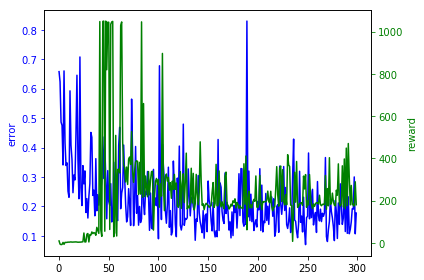

In [12]:

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots()
ax1.plot([e[1] for e in results], 'b-')
#ax1.set_xlabel('time (s)')
ax1.set_ylabel('error', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot([e[2] for e in results], 'g')
ax2.set_ylabel('reward', color='g')
ax2.tick_params('y', colors='g')

fig.tight_layout()
plt.show()


In [16]:
print('''Behavarial cloning for {}.
Expert  policy mean reward {:.2f} and std {:.3f}.
Learned policy mean reward {:.2f} and std {:.3f}.'''.format(
    envname, 
    np.mean([e[0] for e in results][-100:]),
    np.std([e[0] for e in results][-100:]),
    np.mean([e[2] for e in results][-100:]),
    np.std([e[2] for e in results][-100:])
))

Behavarial cloning for Walker2d-v1.
Expert  policy mean reward 5511.26 and std 122.283.
Learned policy mean reward 225.92 and std 80.168.


In [18]:
args = pd.Series({
        'expert_policy_file':'experts/' + envname + '.pkl',
        'envname': envname,
        'max_timesteps': None,
        'num_rollouts':1,
        'render': True
    })
#learn_imitatation_learning(ffn, args)
evaluate_imitation_learning(ffn, args)

[2017-11-02 23:52:33,075] Making new env: Walker2d-v1


[184.00315393578478]